In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [31]:
from Datos import Datos
import EstrategiaParticionado
import Clasificador

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Important to pre-install tabulate (pip install tabulate)
from tabulate import tabulate

clasificador = Clasificador.Clasificador()

In [32]:
final_results_dict = {}

# <font color='red'>1. Entrenamiento y clasificación con Clasificador.py</font>


## <font color='blue'> 1.1 Dataset tic-tac-toe </font>

In [33]:
dataset_ttt = Datos("../ConjuntosDatos/tic-tac-toe.data")
ndata, ncols = dataset_ttt.datos.shape # nfeat = ncols-1 
print("Numero de ejemplos de entrenamiento:", ndata, ", Numero de columnas:", ncols)

Numero de ejemplos de entrenamiento: 958 , Numero de columnas: 10


In [34]:
np.random.shuffle(dataset_ttt.datos)

NB = Clasificador.ClasificadorNaiveBayes()
NB_noLaplace = Clasificador.ClasificadorNaiveBayes(laplace=False)

### 1.1.1 Validación simple

In [35]:
strat_simple = EstrategiaParticionado.ValidacionSimple(0.8)

In [36]:
errores = clasificador.validacion(strat_simple, dataset_ttt, NB)
print("Con Laplace:", errores)
errores2 = clasificador.validacion(strat_simple, dataset_ttt, NB_noLaplace)
print("Sin Laplace:", errores2)

# We will use this result later
final_results_dict['clasificador_val_simple_ttt'] = [np.mean(errores), np.std(errores)]
final_results_dict['clasificador_val_simple_ttt_NL'] = [np.mean(errores2), np.std(errores2)]

Con Laplace: [0.29166666666666663]
Sin Laplace: [0.29166666666666663]


### 1.1.2 Validación simple con varias repeticiones (3 reps)

In [37]:
strat_simple_rep3 = EstrategiaParticionado.ValidacionSimple(0.8, nreps=3)

In [38]:
errores = clasificador.validacion(strat_simple_rep3, dataset_ttt, NB)
print("Errores con Laplace:", errores)
print("Error medio con Laplace:", np.mean(errores), "+-", np.std(errores))
errores2 = clasificador.validacion(strat_simple_rep3, dataset_ttt, NB_noLaplace)
print("Errores sin Laplace:", errores2)
print("Error medio sin Laplace:", np.mean(errores2), "+-", np.std(errores2))

# We will use this result later
final_results_dict['clasificador_val_simple_rep3_ttt'] = [np.mean(errores), np.std(errores)]
final_results_dict['clasificador_val_simple_rep3_ttt_NL'] = [np.mean(errores2), np.std(errores2)]

Errores con Laplace: [0.30208333333333337, 0.32291666666666663, 0.28645833333333337]
Error medio con Laplace: 0.3038194444444445 +- 0.014934592477504529
Errores sin Laplace: [0.25, 0.30208333333333337, 0.28125]
Error medio sin Laplace: 0.2777777777777778 +- 0.021404215288086736


### 1.1.3 Validación Cruzada (5 folds)

In [39]:
strat_cross = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

In [40]:
errores = clasificador.validacion(strat_cross, dataset_ttt, NB)
print("Errores con Laplace:", errores)
print("Error medio con Laplace:", np.mean(errores), "+-", np.std(errores))
errores2 = clasificador.validacion(strat_cross, dataset_ttt, NB_noLaplace)
print("Errores sin Laplace:", errores2)
print("Error medio sin Laplace:", np.mean(errores2), "+-", np.std(errores2))

# We will use this result later
final_results_dict['clasificador_cross_val_ttt'] = [np.mean(errores), np.std(errores)]
final_results_dict['clasificador_cross_val_ttt_NL'] = [np.mean(errores2), np.std(errores2)]

Errores con Laplace: [0.2931937172774869, 0.3089005235602095, 0.3089005235602095, 0.2670157068062827, 0.3036649214659686]
Error medio con Laplace: 0.2963350785340314 +- 0.015741671600390493
Errores sin Laplace: [0.32984293193717273, 0.26178010471204194, 0.2931937172774869, 0.2670157068062827, 0.31413612565445026]
Error medio sin Laplace: 0.29319371727748694 +- 0.02628251392253638


## <font color='blue'> 1.2 Dataset German </font>

In [41]:
dataset_ger = Datos("../ConjuntosDatos/german.data")
ndata, ncols = dataset_ger.datos.shape # nfeat = ncols-1 
print("Numero de ejemplos de entrenamiento:", ndata, ", Numero de columnas:", ncols)

Numero de ejemplos de entrenamiento: 1000 , Numero de columnas: 21


In [42]:
np.random.shuffle(dataset_ger.datos)

### 1.2.1 Validación simple

In [43]:
strat_simple_ger = EstrategiaParticionado.ValidacionSimple(0.8)

errores = clasificador.validacion(strat_simple_ger, dataset_ger, NB)
print("Con Laplace:", errores)
errores2 = clasificador.validacion(strat_simple_ger, dataset_ger, NB_noLaplace)
print("Sin Laplace:", errores2)

# We will use this result later
final_results_dict['clasificador_val_simple_ger'] = [np.mean(errores), np.std(errores)]
final_results_dict['clasificador_val_simple_ger_NL'] = [np.mean(errores2), np.std(errores2)]

Con Laplace: [0.25]
Sin Laplace: [0.28500000000000003]


### 1.2.2 Validación simple con varias repeticiones (3 reps)

In [44]:
strat_simple_rep3_ger = EstrategiaParticionado.ValidacionSimple(0.8, nreps=3)

errores = clasificador.validacion(strat_simple_rep3_ger, dataset_ger, NB)
print("Errores con Laplace:", errores)
print("Error medio con Laplace:", np.mean(errores), "+-", np.std(errores))
errores2 = clasificador.validacion(strat_simple_rep3_ger, dataset_ger, NB_noLaplace)
print("Errores sin Laplace:", errores2)
print("Error medio sin Laplace:", np.mean(errores2), "+-", np.std(errores2))

# We will use this result later
final_results_dict['clasificador_val_simple_rep3_ger'] = [np.mean(errores), np.std(errores)]
final_results_dict['clasificador_val_simple_rep3_ger_NL'] = [np.mean(errores2), np.std(errores2)]

Errores con Laplace: [0.24, 0.28, 0.20999999999999996]
Error medio con Laplace: 0.24333333333333332 +- 0.02867441755680878
Errores sin Laplace: [0.27, 0.21999999999999997, 0.22999999999999998]
Error medio sin Laplace: 0.24 +- 0.021602468994692887


### 1.2.3 Validación cruzada (5 folds)

In [45]:
strat_cross_ger = EstrategiaParticionado.ValidacionCruzada(k_fold=3)

errores = clasificador.validacion(strat_cross_ger, dataset_ger, NB)
print("Errores con Laplace:", errores)
print("Error medio con Laplace:", np.mean(errores), "+-", np.std(errores))
errores2 = clasificador.validacion(strat_cross_ger, dataset_ger, NB_noLaplace)
print("Errores sin Laplace:", errores2)
print("Error medio sin Laplace:", np.mean(errores2), "+-", np.std(errores2))

# We will use this result later
final_results_dict['clasificador_cross_val_ger'] = [np.mean(errores), np.std(errores)]
final_results_dict['clasificador_cross_val_ger_NL'] = [np.mean(errores2), np.std(errores2)]

Errores con Laplace: [0.2492492492492493, 0.27627627627627627, 0.2552552552552553]
Error medio con Laplace: 0.2602602602602603 +- 0.011587424327117322
Errores sin Laplace: [0.23123123123123124, 0.24624624624624625, 0.26726726726726724]
Error medio sin Laplace: 0.24824824824824823 +- 0.014779602662896282


## <font color='green'> 1.3 Tablas de Resultados (Clasificador.py)</font>

Anteriormente hemos visto los resultados para ambos conjuntos de datos, utilizando las 3 estrategias de particionado que hemos implementado y comparando la eficacia de la corrección de Laplace en cada apartado. Como se ha visto que la corrección de Laplace, por lo general, mejora el rendimiento del clasificador, también la utilizaremos en esta subsección para resumir los resultados finales de Clasificador.py

###  1.3.1 Validación simple con número variable de repeticiones

In [46]:
def val_simple(percentage):
    max_reps = 5
    L = []
    for i in range(1, max_reps+1):
        L.append([])
        strat = EstrategiaParticionado.ValidacionSimple(percentage, nreps=i)
        errores_ttt = clasificador.validacion(strat, dataset_ttt, NB)
        errores_ger = clasificador.validacion(strat, dataset_ger, NB)
        L[i-1].append(str(i))
        L[i-1].append("%.2f +- %.3f"% (np.mean(errores_ttt), np.std(errores_ttt)))
        L[i-1].append("%.2f +- %.3f"% (np.mean(errores_ger), np.std(errores_ger)))
    print("Validación Simple con " + str(int(percentage*100)) +   "% Train\n")
    print(tabulate(L, headers = ["N_REPS", "TTT_DB", "GER_DB"], tablefmt="grid")) 

In [47]:
val_simple(0.70)

Validación Simple con 70% Train

+----------+---------------+---------------+
|   N_REPS | TTT_DB        | GER_DB        |
+==========+===============+===============+
|        1 | 0.26 +- 0.000 | 0.26 +- 0.000 |
+----------+---------------+---------------+
|        2 | 0.28 +- 0.019 | 0.25 +- 0.010 |
+----------+---------------+---------------+
|        3 | 0.30 +- 0.023 | 0.26 +- 0.016 |
+----------+---------------+---------------+
|        4 | 0.31 +- 0.016 | 0.23 +- 0.032 |
+----------+---------------+---------------+
|        5 | 0.29 +- 0.014 | 0.27 +- 0.021 |
+----------+---------------+---------------+


In [48]:
val_simple(0.75)

Validación Simple con 75% Train

+----------+---------------+---------------+
|   N_REPS | TTT_DB        | GER_DB        |
+==========+===============+===============+
|        1 | 0.30 +- 0.000 | 0.25 +- 0.000 |
+----------+---------------+---------------+
|        2 | 0.33 +- 0.008 | 0.28 +- 0.022 |
+----------+---------------+---------------+
|        3 | 0.28 +- 0.003 | 0.26 +- 0.015 |
+----------+---------------+---------------+
|        4 | 0.28 +- 0.019 | 0.24 +- 0.036 |
+----------+---------------+---------------+
|        5 | 0.30 +- 0.009 | 0.24 +- 0.016 |
+----------+---------------+---------------+


In [49]:
val_simple(0.80)

Validación Simple con 80% Train

+----------+---------------+---------------+
|   N_REPS | TTT_DB        | GER_DB        |
+==========+===============+===============+
|        1 | 0.28 +- 0.000 | 0.22 +- 0.000 |
+----------+---------------+---------------+
|        2 | 0.31 +- 0.047 | 0.27 +- 0.015 |
+----------+---------------+---------------+
|        3 | 0.30 +- 0.024 | 0.26 +- 0.030 |
+----------+---------------+---------------+
|        4 | 0.30 +- 0.036 | 0.26 +- 0.017 |
+----------+---------------+---------------+
|        5 | 0.30 +- 0.031 | 0.26 +- 0.028 |
+----------+---------------+---------------+


### 1.3.2 Validación cruzada

In [50]:
max_folds = 11
j = 0
L = []
for i in range(3, max_folds+1, 2):
    L.append([])
    strat = EstrategiaParticionado.ValidacionCruzada(k_fold=i)
    errores_ttt = clasificador.validacion(strat, dataset_ttt, NB)
    errores_ger = clasificador.validacion(strat, dataset_ger, NB)
    L[j].append(str(i))
    L[j].append("%.2f +- %.3f"% (np.mean(errores_ttt), np.std(errores_ttt)))
    L[j].append("%.2f +- %.3f"% (np.mean(errores_ger), np.std(errores_ger)))
    j+=1
print(tabulate(L, headers = ["K_FOLDS", "TTT_DB", "GER_DB"], tablefmt="grid"))

+-----------+---------------+---------------+
|   K_FOLDS | TTT_DB        | GER_DB        |
+===========+===============+===============+
|         3 | 0.29 +- 0.019 | 0.26 +- 0.030 |
+-----------+---------------+---------------+
|         5 | 0.31 +- 0.054 | 0.25 +- 0.019 |
+-----------+---------------+---------------+
|         7 | 0.30 +- 0.032 | 0.25 +- 0.064 |
+-----------+---------------+---------------+
|         9 | 0.30 +- 0.024 | 0.25 +- 0.026 |
+-----------+---------------+---------------+
|        11 | 0.31 +- 0.049 | 0.25 +- 0.055 |
+-----------+---------------+---------------+


# <font color='red'>2. Entrenamiento y clasificación con funciones de sklearn (encapsuladas en Clasificador.py)</font>

In [51]:
# Las funciones de sklearn requieren una codificación de los atributos discretos diferente a la nuestra.
# Por lo tanto, realizamos un pequeño trabajo de preprocesado de datos para que sus funciones de sklearn
# puiedan realizar un entrenamiento y clasificación equiparable al nuestro

def preprocess_data(dataset):
    X = dataset.datos[:,:-1] # all rows, all columns but last one
    Y = dataset.datos[:,-1]  # all rows, just last column (class)
    
    # One hot encoding for discrete features
    enc = OneHotEncoder(sparse=False, categories='auto')
    X_enc = np.array(enc.fit_transform(X)) 
    # Concatenating encoded data matrix and classes
    datos_aux = np.concatenate((X_enc, Y[:,None]), axis=1)
    # Updating dataset
    dataset.datos = np.zeros(datos_aux.shape)
    dataset.datos = datos_aux
    return dataset 

## <font color='blue'> 2.1 Dataset tic-tac-toe </font>

In [52]:
ttt_db = Datos('../ConjuntosDatos/tic-tac-toe.data')
ndata, ncols = ttt_db.datos.shape # nfeat = ncols-1 
print("Numero de ejemplos de entrenamiento:", ndata, ", Numero de columnas:", ncols)

Numero de ejemplos de entrenamiento: 958 , Numero de columnas: 10


In [53]:
ttt_db = preprocess_data(ttt_db)
np.random.shuffle(ttt_db.datos)

NBSK = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False)
NBSK_noLaplace = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False, laplace=False)

### 2.1.1 Validación simple

In [54]:
strat_simple_sk = EstrategiaParticionado.ValidacionSimple(0.8)

errores = clasificador.validacion(strat_simple_sk, ttt_db, NBSK)
print("Con laplace", errores)
errores2 = clasificador.validacion(strat_simple_sk, ttt_db, NBSK_noLaplace)
print("Sin laplace", errores2)

# We will use this result later
final_results_dict['sklearn_val_simple_ttt'] = [np.mean(errores), np.std(errores)]
final_results_dict['sklearn_val_simple_ttt_NL'] = [np.mean(errores2), np.std(errores2)]


Con laplace [0.28645833333333337]
Sin laplace [0.32291666666666663]


/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


En primer lugar, vemos que la librería de Scikit-learn nos advierte que asignar alpha=0 (desactivar corrección de Laplace) desembocará en errores numéricos, y que alpha pasará a valer 10^{-10}. No nos importa mucho este cambio ya que este valor es terriblemente cercano a cero, pudiendo considerar que efectivamente se desactiva la corrección de Laplace de la librería scikit-learn.

Como este warning va a perdurar por el resto del notebook, vamos a desactivar estos avisos para no sobrecargar el fichero. Esto es lo que hacen las dos siguientes líneas.

In [55]:
import warnings
warnings.filterwarnings('ignore')

### 2.1.2 Validación simple con varias repeticiones (3 reps)

In [56]:
strat_simple_rep3_sk = EstrategiaParticionado.ValidacionSimple(0.8, nreps=3)

errores = clasificador.validacion(strat_simple_rep3_sk, ttt_db, NBSK)
print("Errores con Laplace: ", errores)
print("Error medio con Laplace:", np.mean(errores), "+-", np.std(errores))
errores2 = clasificador.validacion(strat_simple_rep3_sk, ttt_db, NBSK_noLaplace)
print("Errores sin Laplace: ", errores2)
print("Error medio sin Laplace:", np.mean(errores2), "+-", np.std(errores2))

# We will use this result later
final_results_dict['sklearn_val_simple_rep3_ttt'] = [np.mean(errores), np.std(errores)]
final_results_dict['sklearn_val_simple_rep3_ttt_NL'] = [np.mean(errores2), np.std(errores2)]

Errores con Laplace:  [0.30208333333333337, 0.24479166666666663, 0.296875]
Error medio con Laplace: 0.28125 +- 0.02586747296137388
Errores sin Laplace:  [0.296875, 0.30208333333333337, 0.30729166666666663]
Error medio sin Laplace: 0.3020833333333333 +- 0.004252586358998558


### 2.1.3 Validacion cruzada (5 folds)

In [57]:
strat_cross_sk = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

errores = clasificador.validacion(strat_cross_sk, ttt_db, NBSK)
print("Errores con Laplace: ", errores)
print("Error medio con Laplace:", np.mean(errores), "+-", np.std(errores))
errores2 = clasificador.validacion(strat_cross_sk, ttt_db, NBSK_noLaplace)
print("Errores sin Laplace: ", errores2)
print("Error medio sin Laplace:", np.mean(errores2), "+-", np.std(errores2))

# We will use this result later
final_results_dict['sklearn_cross_val_ttt'] = [np.mean(errores), np.std(errores)]
final_results_dict['sklearn_cross_val_ttt_NL'] = [np.mean(errores2), np.std(errores2)]

Errores con Laplace:  [0.2879581151832461, 0.2931937172774869, 0.3089005235602095, 0.32460732984293195, 0.2827225130890052]
Error medio con Laplace: 0.2994764397905759 +- 0.015318051139610269
Errores sin Laplace:  [0.2984293193717278, 0.3036649214659686, 0.33507853403141363, 0.26178010471204194, 0.2879581151832461]
Error medio sin Laplace: 0.2973821989528796 +- 0.023739861882208644


## <font color='blue'> 2.2 Dataset German (todos los atributos se consideran discretos)</font>

In [58]:
ger_db = Datos('../ConjuntosDatos/german.data')
ndata, ncols = ger_db.datos.shape # nfeat = ncols-1 
print("Numero de ejemplos de entrenamiento:", ndata, ", Numero de columnas:", ncols)

Numero de ejemplos de entrenamiento: 1000 , Numero de columnas: 21


In [59]:
ger_db = preprocess_data(ger_db)
np.random.shuffle(ger_db.datos)

NBSK = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False)
NBSK_noLaplace = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False, laplace=False)

### 2.2.1 Validación simple

In [60]:
strat_simple_sk = EstrategiaParticionado.ValidacionSimple(0.8)

errores = clasificador.validacion(strat_simple_sk, ger_db, NBSK)
print("Con Laplace:", errores)
errores2 = clasificador.validacion(strat_simple_sk, ger_db, NBSK_noLaplace)
print("Con Laplace:", errores2)

# We will use this result later
final_results_dict['sklearn_val_simple_gerDiscr'] = [np.mean(errores), np.std(errores)]
final_results_dict['sklearn_val_simple_gerDiscr_NL'] = [np.mean(errores2), np.std(errores2)]

Con Laplace: [0.29000000000000004]
Con Laplace: [0.31000000000000005]


### 2.2.2 Validación simple con varias repeticiones (3 reps)

In [61]:
strat_simple_rep3_sk = EstrategiaParticionado.ValidacionSimple(0.8, nreps=3)

errores = clasificador.validacion(strat_simple_rep3_sk, ger_db, NBSK)
print("Errores con Laplace: ", errores)
print("Error medio con Laplace:", np.mean(errores), "+-", np.std(errores))
errores2 = clasificador.validacion(strat_simple_rep3_sk, ger_db, NBSK_noLaplace)
print("Errores sin Laplace: ", errores2)
print("Error medio sin Laplace:", np.mean(errores2), "+-", np.std(errores2))

# We will use this result later
final_results_dict['sklearn_val_simple_rep3_gerDiscr'] = [np.mean(errores), np.std(errores)]
final_results_dict['sklearn_val_simple_rep3_gerDiscr_NL'] = [np.mean(errores2), np.std(errores2)]

Errores con Laplace:  [0.27, 0.31999999999999995, 0.30500000000000005]
Error medio con Laplace: 0.29833333333333334 +- 0.020949675149960875
Errores sin Laplace:  [0.31999999999999995, 0.31000000000000005, 0.33499999999999996]
Error medio sin Laplace: 0.32166666666666666 +- 0.010274023338281594


### 2.2.3 Validación cruzada (5 folds)

In [62]:
strat_cross_sk = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

errores = clasificador.validacion(strat_cross_sk, ger_db, NBSK)
print("Errores con Laplace: ", errores)
print("Error medio con Laplace:", np.mean(errores), "+-", np.std(errores))
errores2 = clasificador.validacion(strat_cross_sk, ger_db, NBSK_noLaplace)
print("Errores sin Laplace: ", errores2)
print("Error medio sin Laplace:", np.mean(errores2), "+-", np.std(errores2))

# We will use this result later
final_results_dict['sklearn_cross_val_gerDiscr'] = [np.mean(errores), np.std(errores)]
final_results_dict['sklearn_cross_val_gerDiscr_NL'] = [np.mean(errores2), np.std(errores2)]

Errores con Laplace:  [0.32999999999999996, 0.245, 0.26, 0.27, 0.25]
Error medio con Laplace: 0.271 +- 0.030724582991474417
Errores sin Laplace:  [0.32999999999999996, 0.29500000000000004, 0.32999999999999996, 0.33999999999999997, 0.28]
Error medio sin Laplace: 0.315 +- 0.02323790007724447


## <font color='blue'> 2.3 Dataset German (todos los atributos se consideran continuos)</font>

In [63]:
ger_db_cont = Datos('../ConjuntosDatos/german.data')
ndata, ncols = ger_db_cont.datos.shape # nfeat = ncols-1 
print("Numero de ejemplos de entrenamiento:", ndata, ", Numero de columnas:", ncols)

Numero de ejemplos de entrenamiento: 1000 , Numero de columnas: 21


In [64]:
np.random.shuffle(ger_db.datos)

NBSK = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=True)

### 2.3.1 Validación simple

In [65]:
strat_simple_sk = EstrategiaParticionado.ValidacionSimple(0.8)

errores = clasificador.validacion(strat_simple_sk, ger_db_cont, NBSK)
print(errores)

# We will use this result later
final_results_dict['sklearn_val_simple_gerCont'] = [np.mean(errores), np.std(errores)]

[0.21499999999999997]


### 2.3.2 Validación simple con varias repeticiones (3 reps)

In [66]:
strat_simple_rep3_sk = EstrategiaParticionado.ValidacionSimple(0.8, nreps=3)

errores = clasificador.validacion(strat_simple_rep3_sk, ger_db_cont, NBSK)

print("Errores: ", errores)
print("Error medio:", np.mean(errores), "+-", np.std(errores))

# We will use this result later
final_results_dict['sklearn_val_simple_rep3_gerCont'] = [np.mean(errores), np.std(errores)]

Errores:  [0.245, 0.32499999999999996, 0.27]
Error medio: 0.27999999999999997 +- 0.03341656275960568


### 2.3.3 Validación cruzada (5 folds)

In [67]:
strat_cross_sk = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

errores = clasificador.validacion(strat_cross_sk, ger_db_cont, NBSK)

print("Errores: ", errores)
print("Error medio:", np.mean(errores), "+-", np.std(errores))

# We will use this result later
final_results_dict['sklearn_cross_val_gerCont'] = [np.mean(errores), np.std(errores)]

Errores:  [0.245, 0.28, 0.25, 0.29000000000000004, 0.265]
Error medio: 0.266 +- 0.017146428199482262


## <font color='green'> 2.4 Tablas de Resultados de sklearn</font>

De nuevo hemos visto los resultados para ambos conjuntos de datos, utilizando las 3 estrategias de particionado que hemos implementado y comparando la eficacia de la corrección de Laplace en cada apartado del caso discreto. Como se ha visto que la corrección de Laplace, por lo general, mejora el rendimiento del clasificador, también la utilizaremos en esta subsección para resumir los resultados finales de scikit-learn

### 2.4.1 Validación simple con número variable de repeticiones

In [68]:
def val_simpleSK(percentage):
    dataset_ttt = Datos("../ConjuntosDatos/tic-tac-toe.data")
    dataset_ger_d = Datos("../ConjuntosDatos/german.data")    # Dataset para el caso Discreto
    dataset_ger_c = Datos("../ConjuntosDatos/german.data")    # Dataset para el caso Continuo
    np.random.shuffle(dataset_ttt.datos)
    np.random.shuffle(dataset_ger_d.datos)
    np.random.shuffle(dataset_ger_c.datos)
    NBSK = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False) # Clasificador Para TTT
    NBSK_d = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False) # Clasificador Para GER en caso Discreto
    NBSK_c = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=True) # Clasificador Para GER en caso Continuo
    max_reps = 5
    L = []
    for i in range(1, max_reps+1):
        L.append([])
        strat = EstrategiaParticionado.ValidacionSimple(percentage, nreps=i)
        errores_ttt = clasificador.validacion(strat, preprocess_data(dataset_ttt), NBSK)
        errores_ger_d = clasificador.validacion(strat, preprocess_data(dataset_ger_d), NBSK_d)
        errores_ger_c = clasificador.validacion(strat, dataset_ger_c, NBSK_c)
        L[i-1].append(str(i))
        L[i-1].append("%.2f +- %.3f"% (np.mean(errores_ttt), np.std(errores_ttt)))
        L[i-1].append("%.2f +- %.3f"% (np.mean(errores_ger_d), np.std(errores_ger_d)))
        L[i-1].append("%.2f +- %.3f"% (np.mean(errores_ger_c), np.std(errores_ger_c)))
    print("Validación Simple con " + str(int(percentage*100)) +   "% Train\n")
    print(tabulate(L, headers = ["N_REPS", "TTT_DB", "GER_DB_D", "GER_DB_C"], tablefmt="grid")) 

In [69]:
val_simpleSK(0.7)

Validación Simple con 70% Train

+----------+---------------+---------------+---------------+
|   N_REPS | TTT_DB        | GER_DB_D      | GER_DB_C      |
+==========+===============+===============+===============+
|        1 | 0.34 +- 0.000 | 0.27 +- 0.000 | 0.22 +- 0.000 |
+----------+---------------+---------------+---------------+
|        2 | 0.34 +- 0.012 | 0.26 +- 0.003 | 0.27 +- 0.000 |
+----------+---------------+---------------+---------------+
|        3 | 0.34 +- 0.030 | 0.27 +- 0.000 | 0.27 +- 0.017 |
+----------+---------------+---------------+---------------+
|        4 | 0.34 +- 0.015 | 0.25 +- 0.019 | 0.27 +- 0.039 |
+----------+---------------+---------------+---------------+
|        5 | 0.35 +- 0.031 | 0.26 +- 0.028 | 0.28 +- 0.008 |
+----------+---------------+---------------+---------------+


In [70]:
val_simpleSK(0.75)

Validación Simple con 75% Train

+----------+---------------+---------------+---------------+
|   N_REPS | TTT_DB        | GER_DB_D      | GER_DB_C      |
+==========+===============+===============+===============+
|        1 | 0.27 +- 0.000 | 0.32 +- 0.000 | 0.24 +- 0.000 |
+----------+---------------+---------------+---------------+
|        2 | 0.32 +- 0.023 | 0.27 +- 0.004 | 0.28 +- 0.024 |
+----------+---------------+---------------+---------------+
|        3 | 0.33 +- 0.022 | 0.25 +- 0.023 | 0.26 +- 0.014 |
+----------+---------------+---------------+---------------+
|        4 | 0.34 +- 0.027 | 0.26 +- 0.020 | 0.29 +- 0.029 |
+----------+---------------+---------------+---------------+
|        5 | 0.34 +- 0.025 | 0.27 +- 0.019 | 0.29 +- 0.013 |
+----------+---------------+---------------+---------------+


In [71]:
val_simpleSK(0.80)

Validación Simple con 80% Train

+----------+---------------+---------------+---------------+
|   N_REPS | TTT_DB        | GER_DB_D      | GER_DB_C      |
+==========+===============+===============+===============+
|        1 | 0.26 +- 0.000 | 0.30 +- 0.000 | 0.26 +- 0.000 |
+----------+---------------+---------------+---------------+
|        2 | 0.29 +- 0.000 | 0.27 +- 0.005 | 0.30 +- 0.010 |
+----------+---------------+---------------+---------------+
|        3 | 0.34 +- 0.036 | 0.24 +- 0.021 | 0.24 +- 0.002 |
+----------+---------------+---------------+---------------+
|        4 | 0.35 +- 0.044 | 0.27 +- 0.014 | 0.26 +- 0.016 |
+----------+---------------+---------------+---------------+
|        5 | 0.33 +- 0.031 | 0.25 +- 0.030 | 0.28 +- 0.029 |
+----------+---------------+---------------+---------------+


### 2.4.2 Validación cruzada 

In [72]:
dataset_ger_d = Datos("../ConjuntosDatos/german.data")    # Dataset para el caso Discreto
dataset_ger_c = Datos("../ConjuntosDatos/german.data")    # Dataset para el caso Continuo
np.random.shuffle(dataset_ger_d.datos)
np.random.shuffle(dataset_ger_c.datos)

preprocess_data(dataset_ger_d)

NBSK = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False) # Clasificador Para TTT
NBSK_d = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False) # Clasificador Para GER en caso Discreto
NBSK_c = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=True) # Clasificador Para GER en caso Continuo

max_folds = 11
j = 0
L = []
for i in range(3, max_folds+1, 2):
    L.append([])
    strat = EstrategiaParticionado.ValidacionCruzada(k_fold=i)
    errores_ttt = clasificador.validacion(strat, dataset_ttt, NBSK)
    errores_ger_d = clasificador.validacion(strat, dataset_ger_d, NBSK_d)
    errores_ger_c = clasificador.validacion(strat, dataset_ger_c, NBSK_c)
    L[j].append(str(i))
    L[j].append("%.2f +- %.3f"% (np.mean(errores_ttt), np.std(errores_ttt)))
    L[j].append("%.2f +- %.3f"% (np.mean(errores_ger_d), np.std(errores_ger_d)))
    L[j].append("%.2f +- %.3f"% (np.mean(errores_ger_c), np.std(errores_ger_c)))
    j+=1
print(tabulate(L, headers = ["K_FOLDS", "TTT_DB", "GER_DB_D", "GER_DB_C"], tablefmt="grid")) 

+-----------+---------------+---------------+---------------+
|   K_FOLDS | TTT_DB        | GER_DB_D      | GER_DB_C      |
+===========+===============+===============+===============+
|         3 | 0.34 +- 0.034 | 0.28 +- 0.025 | 0.26 +- 0.011 |
+-----------+---------------+---------------+---------------+
|         5 | 0.34 +- 0.017 | 0.27 +- 0.034 | 0.27 +- 0.035 |
+-----------+---------------+---------------+---------------+
|         7 | 0.34 +- 0.050 | 0.27 +- 0.046 | 0.26 +- 0.013 |
+-----------+---------------+---------------+---------------+
|         9 | 0.34 +- 0.045 | 0.27 +- 0.037 | 0.27 +- 0.049 |
+-----------+---------------+---------------+---------------+
|        11 | 0.34 +- 0.049 | 0.26 +- 0.046 | 0.27 +- 0.032 |
+-----------+---------------+---------------+---------------+


# <font color='red'>3. Resultados finales (Clasificador.py + sklearn) </font>

A pesar de haber realizado ya exposiciones de los errores de Clasificador.py y sklearn en sus correspondientes secciones, en este apartado vamos a juntar ciertos resultados para tener una imagen más clara en conjunto.

Por razones de brevedad, consideraremos solo las particiones:
- Validación simple (80% train, 20% test)
- Validación simple con 3 repeticiones
- Validación cruzada con 5 folds

In [73]:
def format_error(error_list):
    return "%.2f +- %.3f"%(error_list[0], error_list[1]) # index 0 = mean value ; index 1 = std value

    
def print_final_results(res_dict):
    headers = ['Model', 'tic-tac-toe', 'german (aprox. discreta)', 'german (aprox. continua)']
    L = []
    L.append(['Clasificador val simple',
              format_error(res_dict['clasificador_val_simple_ttt']),
              format_error(res_dict['clasificador_val_simple_ger']),
              format_error(res_dict['clasificador_val_simple_ger'])])
    L.append(['Clasificador val simple noLaplace',
              format_error(res_dict['clasificador_val_simple_ttt_NL']),
              format_error(res_dict['clasificador_val_simple_ger_NL']),
              format_error(res_dict['clasificador_val_simple_ger_NL'])])
    L.append(['Clasificador val simple nreps=3',
              format_error(res_dict['clasificador_val_simple_rep3_ttt']),
              format_error(res_dict['clasificador_val_simple_rep3_ger']),
              format_error(res_dict['clasificador_val_simple_rep3_ger'])])
    L.append(['Clasificador val simple nreps=3 noLaplace',
              format_error(res_dict['clasificador_val_simple_rep3_ttt_NL']),
              format_error(res_dict['clasificador_val_simple_rep3_ger_NL']),
              format_error(res_dict['clasificador_val_simple_rep3_ger_NL'])])
    L.append(['Clasificador val cruzada 5fold',
              format_error(res_dict['clasificador_cross_val_ttt']),
              format_error(res_dict['clasificador_cross_val_ger']),
              format_error(res_dict['clasificador_cross_val_ger'])])
    L.append(['Clasificador val cruzada 5fold noLaplace',
              format_error(res_dict['clasificador_cross_val_ttt_NL']),
              format_error(res_dict['clasificador_cross_val_ger_NL']),
              format_error(res_dict['clasificador_cross_val_ger_NL'])])
    L.append(['skLearn val simple',
              format_error(res_dict['sklearn_val_simple_ttt']),
              format_error(res_dict['sklearn_val_simple_gerDiscr']),
              format_error(res_dict['sklearn_val_simple_gerCont'])])
    L.append(['skLearn val simple noLaplace',
              format_error(res_dict['sklearn_val_simple_ttt_NL']),
              format_error(res_dict['sklearn_val_simple_gerDiscr_NL']),
              "There is no Laplace"])
    L.append(['skLearn val simple nreps=3',
              format_error(res_dict['sklearn_val_simple_rep3_ttt']),
              format_error(res_dict['sklearn_val_simple_rep3_gerDiscr']),
              format_error(res_dict['sklearn_val_simple_rep3_gerCont'])])
    L.append(['skLearn val simple nreps=3 noLaplace',
              format_error(res_dict['sklearn_val_simple_rep3_ttt_NL']),
              format_error(res_dict['sklearn_val_simple_rep3_gerDiscr_NL']),
              "There is no Laplace"])
    L.append(['skLearn val cruzada 5fold',
              format_error(res_dict['sklearn_cross_val_ttt']),
              format_error(res_dict['sklearn_cross_val_gerDiscr']),
              format_error(res_dict['sklearn_cross_val_gerCont'])])
    L.append(['skLearn val cruzada 5fold noLaplace',
              format_error(res_dict['sklearn_cross_val_ttt_NL']),
              format_error(res_dict['sklearn_cross_val_gerDiscr_NL']),
              "There is no Laplace"])
    print(tabulate(L, headers, tablefmt="pretty"))
    

In [74]:
print_final_results(final_results_dict)

+-------------------------------------------+---------------+--------------------------+--------------------------+
|                   Model                   |  tic-tac-toe  | german (aprox. discreta) | german (aprox. continua) |
+-------------------------------------------+---------------+--------------------------+--------------------------+
|          Clasificador val simple          | 0.29 +- 0.000 |      0.25 +- 0.000       |      0.25 +- 0.000       |
|     Clasificador val simple noLaplace     | 0.29 +- 0.000 |      0.29 +- 0.000       |      0.29 +- 0.000       |
|      Clasificador val simple nreps=3      | 0.30 +- 0.015 |      0.24 +- 0.029       |      0.24 +- 0.029       |
| Clasificador val simple nreps=3 noLaplace | 0.28 +- 0.021 |      0.24 +- 0.022       |      0.24 +- 0.022       |
|      Clasificador val cruzada 5fold       | 0.30 +- 0.016 |      0.26 +- 0.012       |      0.26 +- 0.012       |
| Clasificador val cruzada 5fold noLaplace  | 0.29 +- 0.026 |      0.25 

# <font color='red'>4. Análisis ROC </font>

In [75]:
def create_confMatrix(pred, real):
    i = 0
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for pred_val in pred:
        # True negative
        if pred_val==0 and pred_val==real[i]:
            tn += 1
        # False negative
        elif pred_val==0 and pred_val!=real[i]:
            fn += 1
        # True positive
        elif pred_val==1 and pred_val==real[i]:
            tp += 1
        # False positive
        elif pred_val==1 and pred_val!=real[i]:
            fp += 1
        i += 1
    
    return [['PRED POS', tp, fp], ['PRED NEG', fn, tn]]




def print_confMatrix(m):
    headers = ["", "REAL POS", "REAL NEG"]
    print(tabulate(m, headers, tablefmt="grid")) 

In [76]:
def ROC_Analysis(dataset, clf, particionado, print_confMtx=True):
    seed = random.seed(0)
    np.random.shuffle(dataset.datos)
    particionado.creaParticiones(dataset.datos, seed)
    
    TPRs = []
    FPRs = []
    for particion in particionado.particiones:

        datostrain = dataset.datos[particion.indicesTrain, :]
        datostest = dataset.datos[particion.indicesTest, :]
            
        clf.entrenamiento(datostrain, dataset.nominalAtributos, dataset.diccionario)
            
        pred = clf.clasifica(datostest, dataset.nominalAtributos, dataset.diccionario)
        real = datostest[:,-1] 
        
        m = create_confMatrix(pred, real)
        tpr_aux = m[0][1]/(m[0][1] + m[1][1])
        fpr_aux = m[0][2]/(m[0][2] + m[1][2])
        TPRs.append(tpr_aux)
        FPRs.append(fpr_aux)
    
    tpr = np.mean(TPRs)
    fpr = np.mean(FPRs)
    
    if print_confMtx:
        print_confMatrix(m)
        print("Punto espacio ROC: (", fpr, ",", tpr, ")")

    return fpr, tpr
 

In [77]:
def plot_ROC(fpr, tpr, clf_name=None):
    plt.figure()
    
    rand_bins = np.linspace(0, 1, num=30)
    plt.plot(rand_bins, rand_bins, color='blue', linestyle='dashed', label='random clf')
    
    tpr_coords = [0, tpr, 1]
    fpr_coords = [0, fpr, 1]
    plt.plot(fpr_coords, tpr_coords, color='red', label='classifier')
    
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    if clf_name:
        plt.title('ROC space for '+clf_name)
    else:
        plt.title('ROC space')

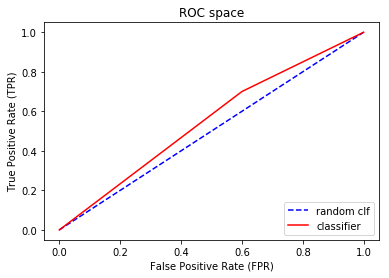

In [78]:
plot_ROC(0.6, 0.7)

## <font color='blue'> 4.1 Dataset tic-tac-toe </font>

In [79]:
db_ttt = Datos("../ConjuntosDatos/tic-tac-toe.data")
db_ttt_sk = Datos("../ConjuntosDatos/tic-tac-toe.data")

np.random.shuffle(db_ttt.datos)
np.random.shuffle(db_ttt_sk.datos)

preprocess_data(db_ttt_sk)

NB = Clasificador.ClasificadorNaiveBayes()
NB_noLaplace = Clasificador.ClasificadorNaiveBayes(laplace=False)
NBSK = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False)

### 4.1.1 Validación simple

In [80]:
strat_simple = EstrategiaParticionado.ValidacionSimple(0.8)

In [81]:
fpr_nb, tpr_nb = ROC_Analysis(db_ttt, NB, strat_simple)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        104 |         47 |
+----------+------------+------------+
| PRED NEG |         12 |         29 |
+----------+------------+------------+
Punto espacio ROC: ( 0.618421052631579 , 0.896551724137931 )


In [82]:
fpr_nb_nl, tpr_nb_nl = ROC_Analysis(db_ttt, NB_noLaplace, strat_simple)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        100 |         44 |
+----------+------------+------------+
| PRED NEG |         16 |         32 |
+----------+------------+------------+
Punto espacio ROC: ( 0.5789473684210527 , 0.8620689655172413 )


In [83]:
fpr_nbsk, tpr_nbsk = ROC_Analysis(db_ttt_sk, NBSK, strat_simple)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        107 |         41 |
+----------+------------+------------+
| PRED NEG |         20 |         24 |
+----------+------------+------------+
Punto espacio ROC: ( 0.6307692307692307 , 0.84251968503937 )


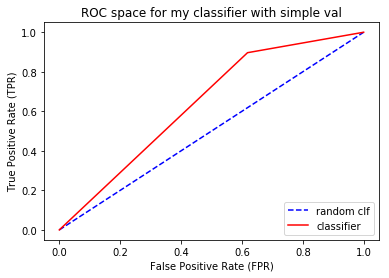

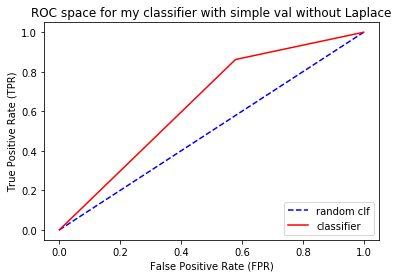

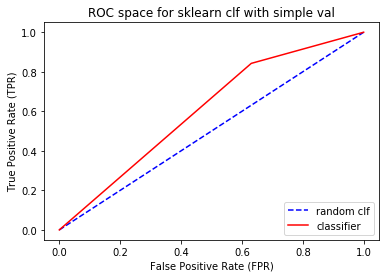

In [84]:
plot_ROC(fpr_nb, tpr_nb, clf_name='my classifier with simple val')
plot_ROC(fpr_nb_nl, tpr_nb_nl, clf_name='my classifier with simple val without Laplace')
plot_ROC(fpr_nbsk, tpr_nbsk, clf_name='sklearn clf with simple val')

### 4.1.2 Validación simple con varias repeticiones

In [85]:
strat_simple_rep3 = EstrategiaParticionado.ValidacionSimple(0.8, nreps=3)

In [86]:
fpr_nb, tpr_nb = ROC_Analysis(db_ttt, NB, strat_simple_rep3)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        112 |         38 |
+----------+------------+------------+
| PRED NEG |         19 |         23 |
+----------+------------+------------+
Punto espacio ROC: ( 0.5559623680150118 , 0.8533132431426576 )


In [87]:
fpr_nbsk, tpr_nbsk = ROC_Analysis(db_ttt_sk, NBSK, strat_simple_rep3)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         91 |         43 |
+----------+------------+------------+
| PRED NEG |         22 |         36 |
+----------+------------+------------+
Punto espacio ROC: ( 0.5515961140544752 , 0.8454881686549194 )


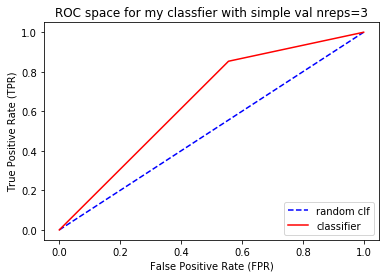

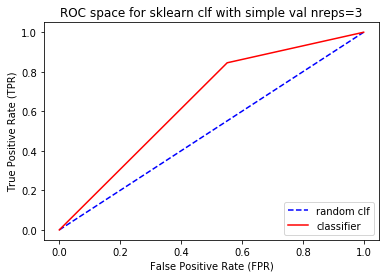

In [88]:
plot_ROC(fpr_nb, tpr_nb, clf_name='my classfier with simple val nreps=3')
plot_ROC(fpr_nbsk, tpr_nbsk, clf_name='sklearn clf with simple val nreps=3')

### 4.1.3 Validación cruzada

In [89]:
strat_cross_val = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

In [90]:
fpr_nb, tpr_nb = ROC_Analysis(db_ttt, NB, strat_cross_val)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         99 |         49 |
+----------+------------+------------+
| PRED NEG |         22 |         21 |
+----------+------------+------------+
Punto espacio ROC: ( 0.5725193658800215 , 0.8546459187833563 )


In [91]:
fpr_nbsk, tpr_nbsk = ROC_Analysis(db_ttt_sk, NBSK, strat_cross_val)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        106 |         41 |
+----------+------------+------------+
| PRED NEG |         23 |         21 |
+----------+------------+------------+
Punto espacio ROC: ( 0.5917667778456972 , 0.8533861151238223 )


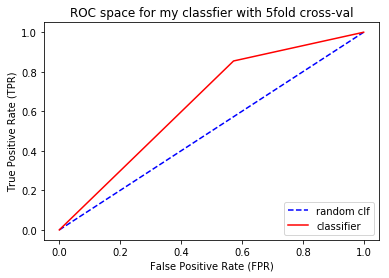

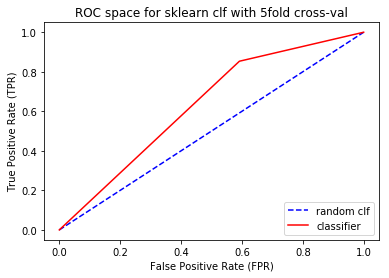

In [92]:
plot_ROC(fpr_nb, tpr_nb, clf_name='my classfier with 5fold cross-val')
plot_ROC(fpr_nbsk, tpr_nbsk, clf_name='sklearn clf with 5fold cross-val')

## <font color='blue'> 4.2 Dataset german </font>

In [93]:
db_ger = Datos("../ConjuntosDatos/tic-tac-toe.data")
db_ger_sk_discr = Datos("../ConjuntosDatos/tic-tac-toe.data")
db_ger_sk_cont = Datos("../ConjuntosDatos/tic-tac-toe.data")

np.random.shuffle(db_ger.datos)
np.random.shuffle(db_ger_sk_discr.datos)
np.random.shuffle(db_ger_sk_cont.datos)

preprocess_data(db_ger_sk_discr)

NB = Clasificador.ClasificadorNaiveBayes()
NBSK_discr = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False)
NBSK_cont = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=True)

### 4.2.1 Validación simple

In [94]:
strat_simple = EstrategiaParticionado.ValidacionSimple(0.8)

In [95]:
fpr_nb, tpr_nb = ROC_Analysis(db_ger, NB, strat_simple)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        112 |         36 |
+----------+------------+------------+
| PRED NEG |         23 |         21 |
+----------+------------+------------+
Punto espacio ROC: ( 0.631578947368421 , 0.8296296296296296 )


In [96]:
fpr_nbsk_discr, tpr_nbsk_discr = ROC_Analysis(db_ger_sk_discr, NBSK_discr, strat_simple)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         97 |         40 |
+----------+------------+------------+
| PRED NEG |         20 |         35 |
+----------+------------+------------+
Punto espacio ROC: ( 0.5333333333333333 , 0.8290598290598291 )


In [97]:
fpr_nbsk_cont, tpr_nbsk_cont = ROC_Analysis(db_ger_sk_cont, NBSK_cont, strat_simple)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        116 |         55 |
+----------+------------+------------+
| PRED NEG |          3 |         18 |
+----------+------------+------------+
Punto espacio ROC: ( 0.7534246575342466 , 0.9747899159663865 )


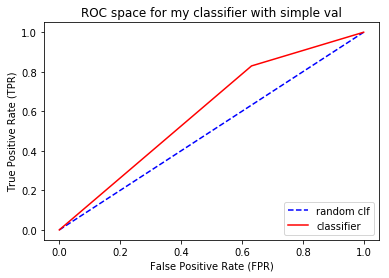

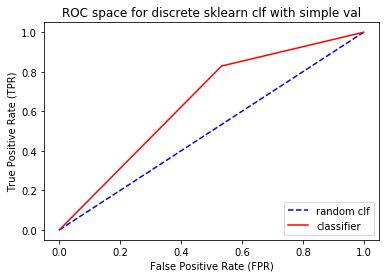

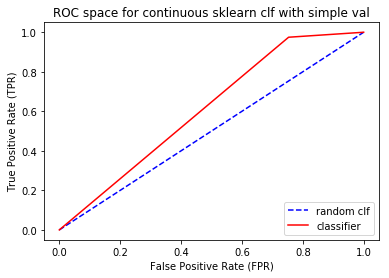

In [98]:
plot_ROC(fpr_nb, tpr_nb, clf_name='my classifier with simple val')
plot_ROC(fpr_nbsk_discr, tpr_nbsk_discr, clf_name='discrete sklearn clf with simple val')
plot_ROC(fpr_nbsk_cont, tpr_nbsk_cont, clf_name='continuous sklearn clf with simple val')

### 4.2.2 Validación simple con varias repeticiones

In [99]:
strat_simple_rep3 = EstrategiaParticionado.ValidacionSimple(0.8, nreps=3)

In [100]:
fpr_nb, tpr_nb = ROC_Analysis(db_ger, NB, strat_simple_rep3)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         99 |         41 |
+----------+------------+------------+
| PRED NEG |         24 |         28 |
+----------+------------+------------+
Punto espacio ROC: ( 0.6189613526570048 , 0.852710027100271 )


In [101]:
fpr_nbsk_discr, tpr_nbsk_discr = ROC_Analysis(db_ger_sk_discr, NBSK_discr, strat_simple_rep3)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        107 |         36 |
+----------+------------+------------+
| PRED NEG |         15 |         34 |
+----------+------------+------------+
Punto espacio ROC: ( 0.5675434362934363 , 0.883672113781606 )


In [102]:
fpr_nbsk_cont, tpr_nbsk_cont = ROC_Analysis(db_ger_sk_cont, NBSK_cont, strat_simple_rep3)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        124 |         58 |
+----------+------------+------------+
| PRED NEG |          2 |          8 |
+----------+------------+------------+
Punto espacio ROC: ( 0.8451479076479077 , 0.9808050092017484 )


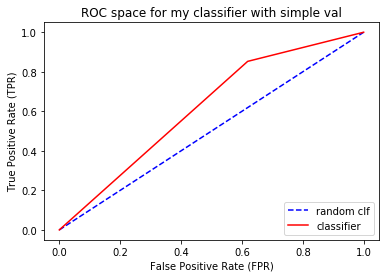

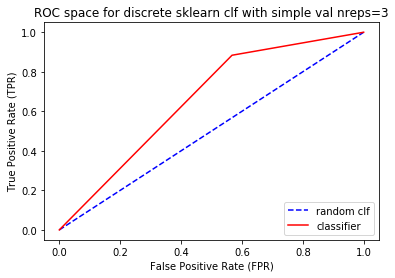

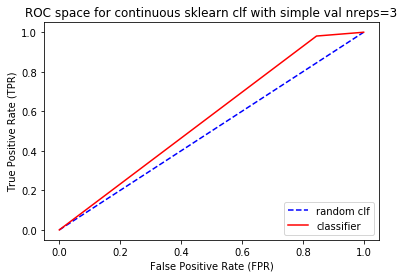

In [103]:
plot_ROC(fpr_nb, tpr_nb, clf_name='my classifier with simple val')
plot_ROC(fpr_nbsk_discr, tpr_nbsk_discr, clf_name='discrete sklearn clf with simple val nreps=3')
plot_ROC(fpr_nbsk_cont, tpr_nbsk_cont, clf_name='continuous sklearn clf with simple val nreps=3')

### 4.2.3 Validación cruzada

In [104]:
strat_cross_val = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

In [105]:
fpr_nb, tpr_nb = ROC_Analysis(db_ger, NB, strat_cross_val)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        103 |         43 |
+----------+------------+------------+
| PRED NEG |         18 |         27 |
+----------+------------+------------+
Punto espacio ROC: ( 0.582024724411377 , 0.8558634971827876 )


In [106]:
fpr_nbsk_discr, tpr_nbsk_discr = ROC_Analysis(db_ger_sk_discr, NBSK_discr, strat_cross_val)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        107 |         42 |
+----------+------------+------------+
| PRED NEG |         19 |         23 |
+----------+------------+------------+
Punto espacio ROC: ( 0.5707836579447834 , 0.8486480423453665 )


In [107]:
fpr_nbsk_cont, tpr_nbsk_cont = ROC_Analysis(db_ger_sk_cont, NBSK_cont, strat_cross_val)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        126 |         51 |
+----------+------------+------------+
| PRED NEG |          0 |         14 |
+----------+------------+------------+
Punto espacio ROC: ( 0.79170939033008 , 0.9807775425000305 )


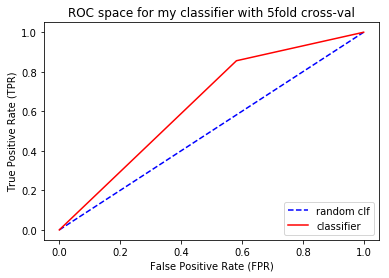

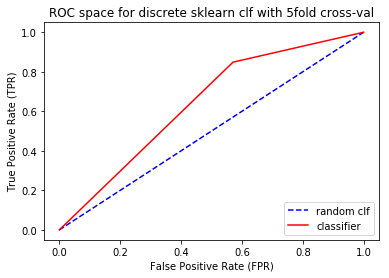

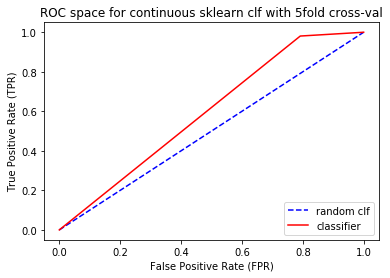

In [108]:
plot_ROC(fpr_nb, tpr_nb, clf_name='my classifier with 5fold cross-val')
plot_ROC(fpr_nbsk_discr, tpr_nbsk_discr, clf_name='discrete sklearn clf with 5fold cross-val')
plot_ROC(fpr_nbsk_cont, tpr_nbsk_cont, clf_name='continuous sklearn clf with 5fold cross-val')